## Imports

In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.layers import LSTM, GRU, Dense, Input, RepeatVector, TimeDistributed, SimpleRNN
from tensorflow.keras.layers import Reshape, GlobalMaxPool1D, Lambda, Concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import Sequence, plot_model
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import random

import pickle

from sklearn.metrics import precision_recall_curve, precision_score, recall_score, accuracy_score
from sklearn.metrics import average_precision_score, roc_auc_score

from sklearn.metrics import multilabel_confusion_matrix

%matplotlib inline

2022-12-30 10:44:32.270915: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
for gpu in physical_devices:
    tf.config.experimental.set_memory_growth(gpu, enable=True)

[]


2022-12-30 10:44:36.038989: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-12-30 10:44:36.039115: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: Lucky
2022-12-30 10:44:36.039155: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: Lucky
2022-12-30 10:44:36.039525: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 525.60.11
2022-12-30 10:44:36.039648: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 525.60.11
2022-12-30 10:44:36.039686: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 525.60.11


In [3]:
with open('./data/xl.pickle', 'rb') as xl_file:
    xl = (pickle.load(xl_file))

with open('./data/yl.pickle', 'rb') as yl_file:
    yl = pickle.load(yl_file)


# Predictive Model

## Understanding the data
There are 50000 records. Each record is a sequence of outputs from 3 sensors.
Each record is multi-labeled, there are 5 types of defects and they are nonexclusive.






In [162]:
df = pd.DataFrame(
    {
        'sequence': xl,
        'defects' : yl
    }
)
df['seq_len'] = df.sequence.map(len)

In [5]:

print(f'minimal length of a sequence: {min(df.seq_len)}')
print(f'maximal length of a sequence: {max(df.seq_len)}')

minimal length of a sequence: 40
maximal length of a sequence: 59


<AxesSubplot: >

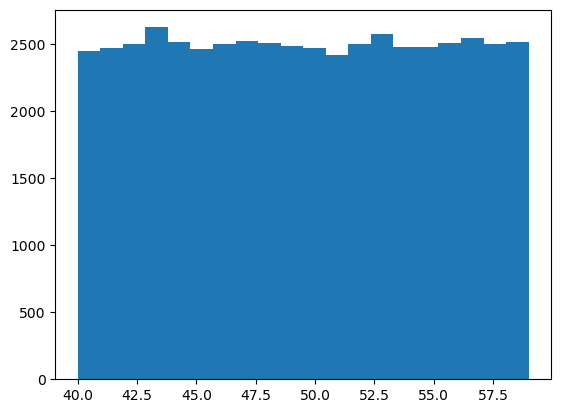

In [6]:
df.seq_len.hist(grid=False, bins=20)

### Issues with the data

#### 1. Training examples vary in length
We can solve this issue with the following approaches:
1. Truncate each training example (then each example has the same lenght and we can easily train our models)
Drawbacks:
- information loss
- labeling errors (if a defect is present in a part of the sequence that has been truncated, then we introduce noise to the data)

2. Write custom data generator that will feed the network with training batches having the same number of samples in each example. (Within a single batch, each training example has to have equal shape, but between batches shapes may vary)



## Data Split
We will use the same splits for all the models, to be able to compare them

In [7]:
df_train = df.iloc[:40000]
df_val = df.iloc[40000:45000]
df_test = df.iloc[45000:]

# defining test array
y_test = np.stack(df_test.defects, axis=0).astype(int)

## Building the models

### 1st approach - truncating the training data


In [70]:



df_train_trunc = df_train.copy()
df_train_trunc.sequence = [sample[:40] for sample in df_train_trunc.sequence]

df_val_trunc = df_val.copy()
df_val_trunc.sequence = [sample[:40] for sample in df_val_trunc.sequence]

df_test_trunc = df_test.copy()
df_test_trunc.sequence = [sample[:40] for sample in df_test_trunc.sequence]


X_train_trunc = np.stack(df_train_trunc.sequence, axis=0)
y_train_trunc = np.stack(df_train_trunc.defects, axis=0)

X_val_trunc = np.stack(df_val_trunc.sequence, axis=0)
y_val_trunc = np.stack(df_val_trunc.defects, axis=0)

X_test_trunc = np.stack(df_test_trunc.sequence, axis=0)
y_test_trunc = np.stack(df_test_trunc.defects, axis=0)

Building the model

In [65]:
model = Sequential()
model.add(LSTM(64, input_shape=(None, 3))) # return_seq = False now
model.add(Dense(5, 'sigmoid'))
model.compile(loss='binary_crossentropy', metrics='acc', optimizer='adam')


Training

In [66]:
early = EarlyStopping(patience=10)

model.fit(X_train_trunc, y_train_trunc, validation_data=(X_val_trunc, y_val_trunc), batch_size=64, epochs=50, callbacks=[early])

Epoch 1/50
625/625 [==============================] - 4s 5ms/step - loss: 0.3795 - acc: 0.4113 - val_loss: 0.3042 - val_acc: 0.4126
Epoch 2/50
625/625 [==============================] - 3s 4ms/step - loss: 0.2892 - acc: 0.4588 - val_loss: 0.2510 - val_acc: 0.5506
Epoch 3/50
625/625 [==============================] - 3s 4ms/step - loss: 0.2514 - acc: 0.4885 - val_loss: 0.2314 - val_acc: 0.4900
Epoch 4/50
625/625 [==============================] - 3s 4ms/step - loss: 0.2343 - acc: 0.4878 - val_loss: 0.2165 - val_acc: 0.4960
Epoch 5/50
625/625 [==============================] - 3s 4ms/step - loss: 0.2210 - acc: 0.4971 - val_loss: 0.2054 - val_acc: 0.4742
Epoch 6/50
625/625 [==============================] - 3s 4ms/step - loss: 0.2113 - acc: 0.5018 - val_loss: 0.2007 - val_acc: 0.4616
Epoch 7/50
625/625 [==============================] - 3s 4ms/step - loss: 0.2016 - acc: 0.5106 - val_loss: 0.2139 - val_acc: 0.6264
Epoch 8/50
625/625 [==============================] - 3s 4ms/step - loss: 0.

Evaluation

In [213]:
y_pred = model.predict(testGenerator).round().astype(int)
model.evaluate(testGenerator)

5000/5000 [==============================] - 26s 5ms/step - loss: 0.1574 - acc: 0.6590


[0.15743444859981537, 0.6589999794960022]

In [214]:
from sklearn.metrics import ConfusionMatrixDisplay

cf = multilabel_confusion_matrix(y_test, y_pred, samplewise=False)
cf


array([[[3730,    6],
        [  14, 1250]],

       [[3754,   11],
        [  15, 1220]],

       [[3072,  690],
        [  20, 1218]],

       [[3740,    1],
        [  21, 1238]],

       [[3724,    0],
        [   0, 1276]]])

In [215]:
from sklearn.metrics import classification_report
print(classification_report(y_test.astype(int), y_pred, target_names=['def1','def2','def3','def4','def5'], zero_division=0))

              precision    recall  f1-score   support

        def1       1.00      0.99      0.99      1264
        def2       0.99      0.99      0.99      1235
        def3       0.64      0.98      0.77      1238
        def4       1.00      0.98      0.99      1259
        def5       1.00      1.00      1.00      1276

   micro avg       0.90      0.99      0.94      6272
   macro avg       0.92      0.99      0.95      6272
weighted avg       0.93      0.99      0.95      6272
 samples avg       0.73      0.76      0.74      6272



Remarks

With this approach we obtain very high precision, but average recall is `0.86`. Low recall may be caused by truncating parts of sequences.

### 2nd approach - feed the NN with batches containing sequences of the same length


In [153]:
class DataGenerator(Sequence):
    def __init__(self, df, batchSize=64, shuffle=True, sequenceToTake=0):
    
        self.sequenceToTake = sequenceToTake
        self.batchSize = batchSize
        self.shuffle = shuffle
        self.df = df
        self.indicies_dict = df.groupby('seq_len').indices
        self.batches = []
        self.generate_batches()

    def on_epoch_end(self):
        '''This function is called at the end of each epoch'''
        self.batches = []
        self.generate_batches()
            
    def generate_batches(self):
        """At the end of each epoch, generate new batches of indices"""
        for key, value in self.indicies_dict.items():
            if self.shuffle:
                random.shuffle(value)
            splitted = np.array_split(value, len(value)//self.batchSize) # FIXME
            self.batches += splitted[:-1]

        if self.shuffle:
            random.shuffle(self.batches)

    def __getitem__(self, index):
        """
        Returns one batch.
        One batch contains the set of sequences of the same length
        """


        x = np.stack(self.df.iloc[self.batches[index], self.sequenceToTake], axis=0)
        y = np.stack(self.df.iloc[self.batches[index], 1], axis=0)

        return x, y

    def __len__(self):
        'Denotes the number of batches per epoch'

        return len(self.batches)

In [154]:
class TestDataGenerator(Sequence):
    """Data generator that passes samples one by one, without shuffling"""
    def __init__(self, df: pd.DataFrame):
        self.df = df.reset_index(inplace=False, drop=True)

    def on_epoch_end(self):
        '''This function is called at the end of each epoch'''
        pass

    def __len__(self):
        'Denotes the number of batches per epoch'
        return self.df.shape[0]
    
    def __getitem__(self, index):
        return np.expand_dims(self.df.iloc[index, 0], axis=0), self.df.iloc[index, 1]

In [218]:
trainGenerator = DataGenerator(df_train)
valGenerator = DataGenerator(df_val, batchSize=16)
testGenerator = TestDataGenerator(df_test)

,sequence,defects,seq_len
0,"[[0.25778191141323037, 0.4816766587494004, 0.2...","[True, False, False, False, True]",48
1,"[[0.7837637256859469, 0.641783855343466, 0.632...","[False, True, False, False, True]",47
2,"[[0.15060546518715953, 0.24562548151974692, 0....","[False, False, False, False, True]",59
3,"[[0.4733923774063066, 0.1612727479939526, 0.25...","[False, False, False, False, False]",58
4,"[[0.7086933605799737, 0.8808554239156839, 0.69...","[True, False, False, False, True]",50


In [219]:
model3 = Sequential()
model3.add(LSTM(64, input_shape=(None, 3))) # return_seq = False now
model3.add(Dense(5, 'sigmoid'))
model3.compile(loss='binary_crossentropy', metrics='acc', optimizer='adam')

In [220]:
early = EarlyStopping(patience=10)

model3.fit(trainGenerator, validation_data= valGenerator, epochs=50, callbacks=[early])

Epoch 1/50
595/595 [==============================] - 7s 8ms/step - loss: 0.3689 - acc: 0.3519 - val_loss: 0.2906 - val_acc: 0.4967
Epoch 2/50
595/595 [==============================] - 4s 7ms/step - loss: 0.2769 - acc: 0.4606 - val_loss: 0.2866 - val_acc: 0.3685
Epoch 3/50
595/595 [==============================] - 4s 7ms/step - loss: 0.2345 - acc: 0.4596 - val_loss: 0.2121 - val_acc: 0.4751
Epoch 4/50
595/595 [==============================] - 4s 7ms/step - loss: 0.2024 - acc: 0.4635 - val_loss: 0.2152 - val_acc: 0.5292
Epoch 5/50
595/595 [==============================] - 4s 7ms/step - loss: 0.1882 - acc: 0.4696 - val_loss: 0.1481 - val_acc: 0.4858
Epoch 6/50
595/595 [==============================] - 4s 7ms/step - loss: 0.1609 - acc: 0.4727 - val_loss: 0.1440 - val_acc: 0.5392
Epoch 7/50
595/595 [==============================] - 4s 7ms/step - loss: 0.1381 - acc: 0.4845 - val_loss: 0.1158 - val_acc: 0.5063
Epoch 8/50
595/595 [==============================] - 4s 7ms/step - loss: 0.

In [22]:
y_pred = model3.predict(testGenerator).round().astype(int)
model3.evaluate(testGenerator)

NameError: name 'model3' is not defined

In [222]:
cf = multilabel_confusion_matrix(y_test.astype(int), y_pred, samplewise=False)
cf

array([[[3736,    0],
        [   1, 1263]],

       [[3765,    0],
        [   5, 1230]],

       [[3754,    8],
        [  37, 1201]],

       [[3741,    0],
        [   0, 1259]],

       [[3724,    0],
        [   0, 1276]]])

In [223]:
print(classification_report(y_test.astype(int), y_pred, target_names=['def1','def2','def3','def4','def5'], zero_division=0))

              precision    recall  f1-score   support

        def1       1.00      1.00      1.00      1264
        def2       1.00      1.00      1.00      1235
        def3       0.99      0.97      0.98      1238
        def4       1.00      1.00      1.00      1259
        def5       1.00      1.00      1.00      1276

   micro avg       1.00      0.99      1.00      6272
   macro avg       1.00      0.99      1.00      6272
weighted avg       1.00      0.99      1.00      6272
 samples avg       0.77      0.77      0.77      6272



# Root cause analysis

Examining what patterns in the data are related to particular defects

1. statistical 
2. denoising ??



In [23]:
df.head()

,sequence,defects,seq_len
0,"[[0.266296985909937, 0.48574277170495817, 0.36...","[False, False, False, False, True]",58
1,"[[0.6106411704068081, 0.9499699673512058, 0.35...","[False, False, False, True, True]",51
2,"[[0.6214531835131287, 0.5707332403433221, 0.78...","[False, False, False, False, False]",59
3,"[[0.6094422267129465, 0.8629181724700395, 0.44...","[True, False, False, False, True]",41
4,"[[0.5072599887415982, 0.766663647815743, 0.325...","[False, True, False, False, False]",47


In [163]:
defects_split = pd.DataFrame(df.defects.to_list(), columns=[f'd{i}' for i in range(1,6)])
df = pd.concat([df, defects_split], axis=1).drop('defects', axis=1)
df.head()

,sequence,seq_len,d1,d2,d3,d4,d5
0,"[[0.266296985909937, 0.48574277170495817, 0.36...",58,False,False,False,False,True
1,"[[0.6106411704068081, 0.9499699673512058, 0.35...",51,False,False,False,True,True
2,"[[0.6214531835131287, 0.5707332403433221, 0.78...",59,False,False,False,False,False
3,"[[0.6094422267129465, 0.8629181724700395, 0.44...",41,True,False,False,False,True
4,"[[0.5072599887415982, 0.766663647815743, 0.325...",47,False,True,False,False,False


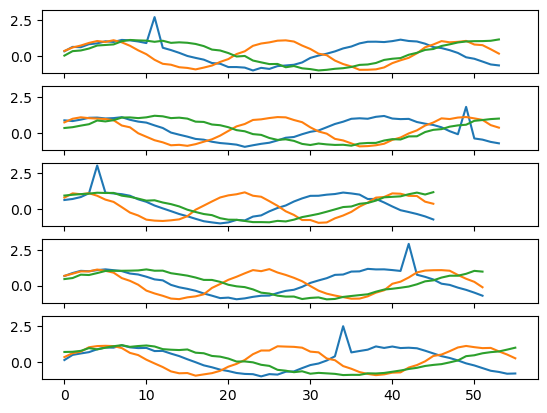

In [45]:
d1_only = df.loc[(df.d1) & (-df.d2) & (-df.d3) & (-df.d4) & (-df.d5)]

fig, ax = plt.subplots(5, sharey=True, sharex=True)

for i in range(5):
    ax[i].plot(d1_only.iloc[i,0])
    
plt.show()

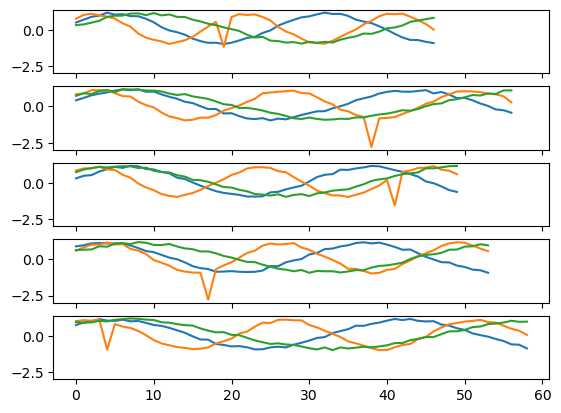

In [46]:
d2_only = df.loc[(-df.d1) & (df.d2) & (-df.d3) & (-df.d4) & (-df.d5)]

fig, ax = plt.subplots(5, sharey=True, sharex=True)

for i in range(5):
    ax[i].plot(d2_only.iloc[i,0])
    
plt.show()

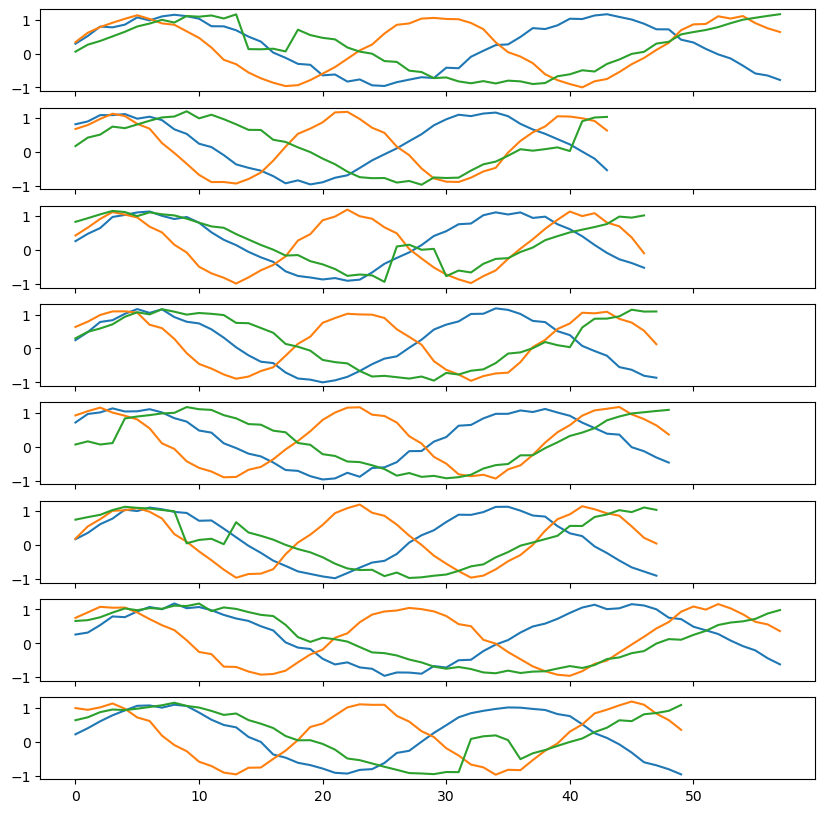

(3940, 7)

In [59]:
d3_only = df.loc[(-df.d1) & (-df.d2) & (df.d3) & (-df.d4) & (-df.d5)]

fig, ax = plt.subplots(8, sharey=True, sharex=True, figsize=(10,10))

for i in range(8):
    ax[i].plot(d3_only.iloc[i,0])
    
plt.show()
d3_only.shape

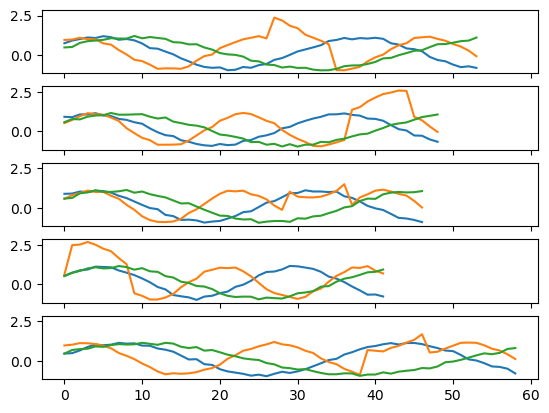

(4120, 7)

In [58]:
d4_only = df.loc[(-df.d1) & (-df.d2) & (-df.d3) & (df.d4) & (-df.d5)]

fig, ax = plt.subplots(5, sharey=True, sharex=True)

for i in range(5):
    ax[i].plot(d4_only.iloc[i,0])
    
plt.show()
d4_only.shape

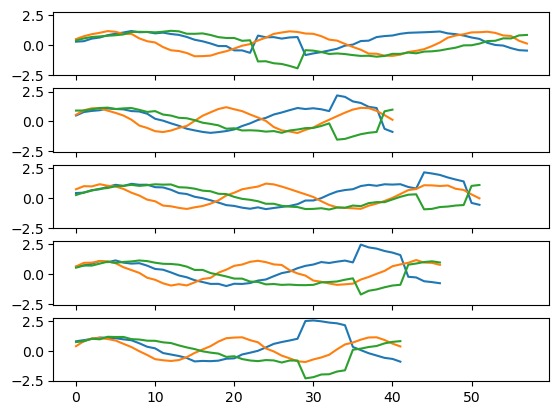

(3919, 7)

In [57]:
d5_only = df.loc[(-df.d1) & (-df.d2) & (-df.d3) & (-df.d4) & (df.d5)]

fig, ax = plt.subplots(5, sharey=True, sharex=True)

for i in range(5):
    ax[i].plot(d5_only.iloc[i,0])
    
plt.show()
d5_only.shape

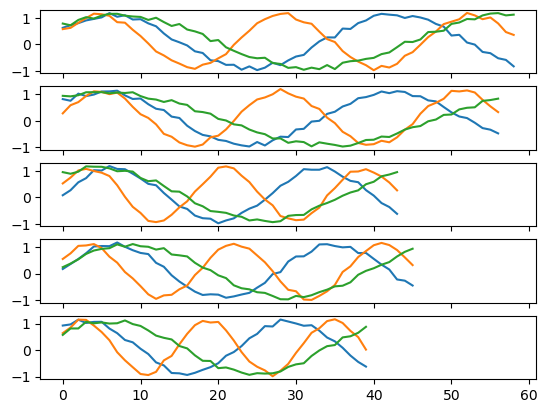

(11723, 7)

In [56]:
no_defect = df.loc[(-df.d1) & (-df.d2) & (-df.d3) & (-df.d4) & (-df.d5)]

fig, ax = plt.subplots(5, sharey=True, sharex=True)

for i in range(5):
    ax[i].plot(no_defect.iloc[i,0])

plt.show()
no_defect.shape

### Correlation between defects

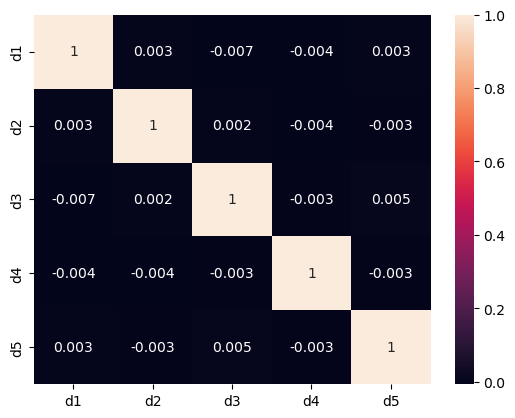

In [64]:
import seaborn as sns

ax = sns.heatmap(defects_split.corr().round(3),annot=True)

We see that all defects are independent, there is no correlation between the occurence ...

In [70]:
no_defect_50 = df.loc[(df.seq_len==50 )& (-df.d1) & (-df.d2) & (-df.d3) & (-df.d4) & (-df.d5)]

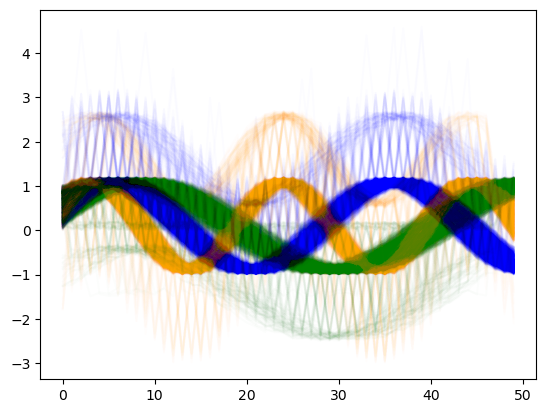

In [82]:

for sample in df.loc[df.seq_len==50].sequence:
    plt.plot(sample[:,0], color='b', alpha= 0.01)
    plt.plot(sample[:,1], color='orange', alpha= 0.01)
    plt.plot(sample[:,2], color='g', alpha= 0.01)

plt.show()

## Defect Localization

### Single Defect Localization

Testing defect detection for 1D sequence
Only to find defect1

In [165]:
df_trunc = df.copy()
df_trunc.sequence =  [sample[:40] for sample in df.sequence]

seq1 = [i[:,0] for i in df_trunc.sequence.to_list()]
seq2 = [i[:,1] for i in df_trunc.sequence.to_list()]
seq3 = [i[:,2] for i in df_trunc.sequence.to_list()]

df_trunc['seq1'] = seq1
df_trunc['seq2'] = seq2
df_trunc['seq3'] = seq3

df_detect_1 = df_trunc.loc[(-df.d2) & (-df.d3) & (-df.d4) & (-df.d5)]
X = np.stack(df_detect_1.seq1,axis=0)
display(X.shape)

y = np.stack(df_detect_1.d1, axis=0)
y.shape

X_train = X[:11000]
y_train = y[:11000]

X_val = X[11000:15000]
y_val = y[11000:15000]

X_test = X[15000:]
y_test = y[15000:]

In [186]:
inner_model = Sequential()
inner_model.add(LSTM(64, return_sequences=True, input_shape=(None,1)))
inner_model.add(LSTM(8, return_sequences=False))
inner_model.add(Dense(1, 'sigmoid'))

inner_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, None, 64)          16896     
                                                                 
 lstm_15 (LSTM)              (None, 8)                 2336      
                                                                 
 dense_9 (Dense)             (None, 1)                 9         
                                                                 
Total params: 19,241
Trainable params: 19,241
Non-trainable params: 0
_________________________________________________________________


In [187]:
INTERVAL_LENGTH = 10


model = Sequential()
model.add(Reshape((-1, INTERVAL_LENGTH, 1), input_shape=(None,1)))
model.add(TimeDistributed(inner_model))
model.add(GlobalMaxPool1D()) # FIXME: 3D ?
model.compile(loss='binary_crossentropy', metrics='acc')
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_3 (Reshape)         (None, None, 10, 1)       0         
                                                                 
 time_distributed_3 (TimeDis  (None, None, 1)          19241     
 tributed)                                                       
                                                                 
 global_max_pooling1d_2 (Glo  (None, 1)                0         
 balMaxPooling1D)                                                
                                                                 
Total params: 19,241
Trainable params: 19,241
Non-trainable params: 0
_________________________________________________________________


In [190]:
model.fit(X_train, y_train, batch_size = 128, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
86/86 [==============================] - 2s 26ms/step - loss: 0.4902 - acc: 0.7932 - val_loss: 0.4756 - val_acc: 0.8053
Epoch 2/20
86/86 [==============================] - 3s 30ms/step - loss: 0.4668 - acc: 0.8127 - val_loss: 0.4732 - val_acc: 0.8039
Epoch 3/20
86/86 [==============================] - 2s 24ms/step - loss: 0.4589 - acc: 0.8158 - val_loss: 0.4496 - val_acc: 0.8291
Epoch 4/20
86/86 [==============================] - 2s 24ms/step - loss: 0.4407 - acc: 0.8288 - val_loss: 0.4421 - val_acc: 0.8291
Epoch 5/20
86/86 [==============================] - 2s 25ms/step - loss: 0.4189 - acc: 0.8408 - val_loss: 0.5298 - val_acc: 0.7381
Epoch 6/20
86/86 [==============================] - 2s 24ms/step - loss: 0.3939 - acc: 0.8488 - val_loss: 0.3870 - val_acc: 0.8599
Epoch 7/20
86/86 [==============================] - 2s 25ms/step - loss: 0.2942 - acc: 0.9004 - val_loss: 0.2350 - val_acc: 0.9272
Epoch 8/20
86/86 [==============================] - 2s 25ms/step - loss: 0.2093 - a

In [191]:
model_slice = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)
model_slice.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_3_input (InputLayer  [(None, None, 1)]        0         
 )                                                               
                                                                 
 reshape_3 (Reshape)         (None, None, 10, 1)       0         
                                                                 
 time_distributed_3 (TimeDis  (None, None, 1)          19241     
 tributed)                                                       
                                                                 
Total params: 19,241
Trainable params: 19,241
Non-trainable params: 0
_________________________________________________________________


1/1 [==============================] - 0s 19ms/step
[0.01456525 0.00962824 0.09426687 0.01358515]


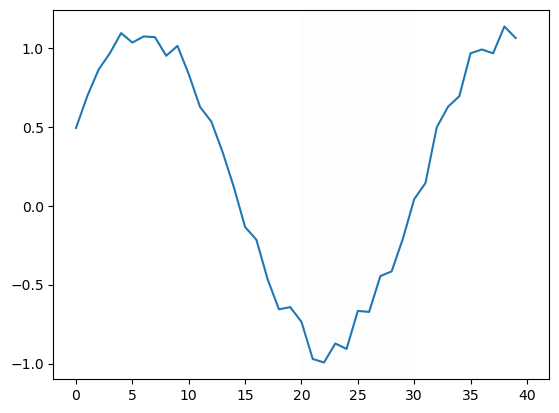

1/1 [==============================] - 0s 16ms/step
[0.0128874  0.00977084 0.06541065 0.01037429]


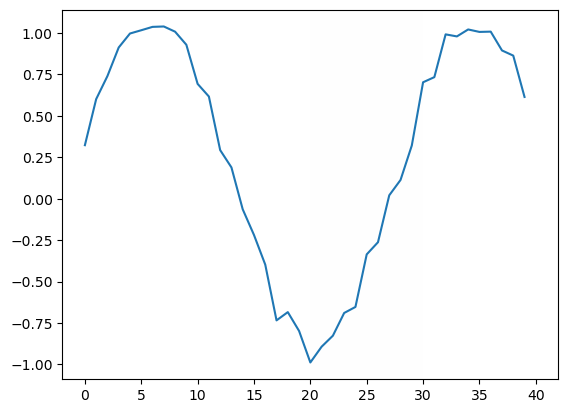

1/1 [==============================] - 0s 19ms/step
[0.01057532 0.0172571  0.01485427 0.00930006]


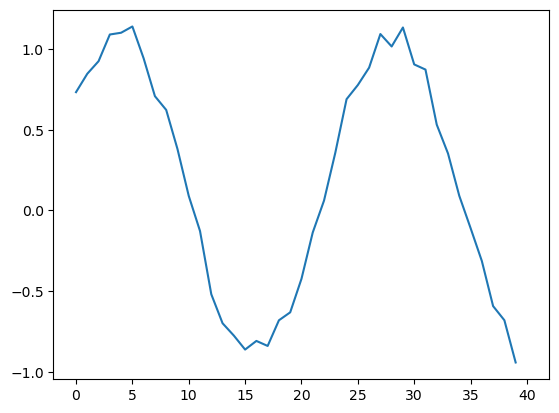

1/1 [==============================] - 0s 16ms/step
[0.01138682 0.0089062  0.08890266 0.01376503]


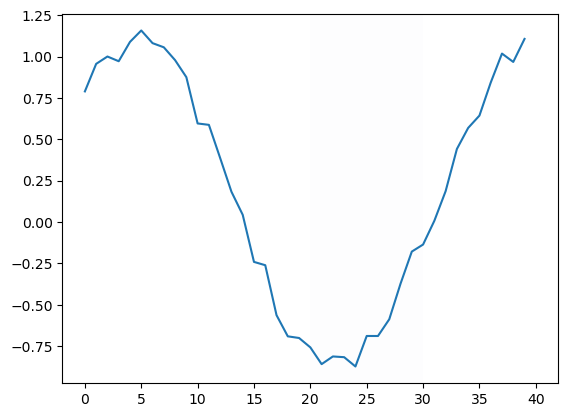

1/1 [==============================] - 0s 25ms/step
[0.0115894  0.00921191 0.8829539  0.01249188]


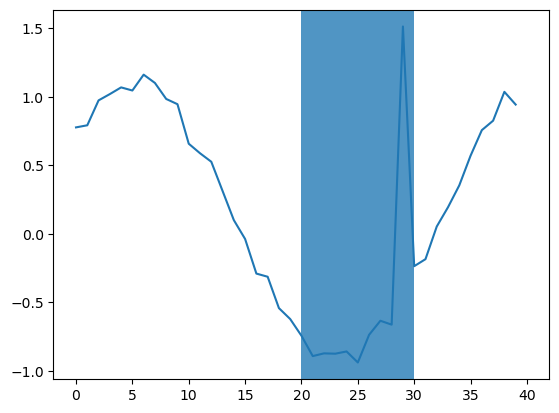

1/1 [==============================] - 0s 17ms/step
[0.01147404 0.00841412 0.08776092 0.01312125]


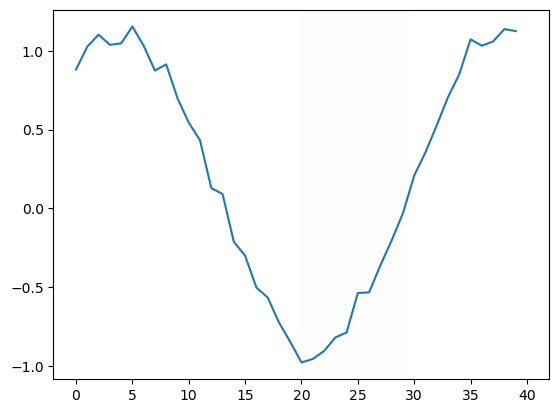

1/1 [==============================] - 0s 17ms/step
[0.01490378 0.01028869 0.09481741 0.0206555 ]


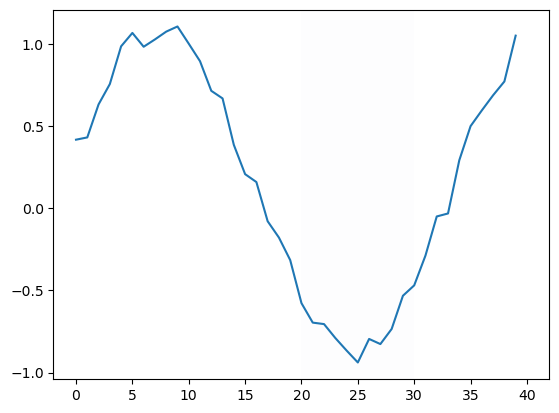

1/1 [==============================] - 0s 15ms/step
[0.00974963 0.00891718 0.07732617 0.9982453 ]


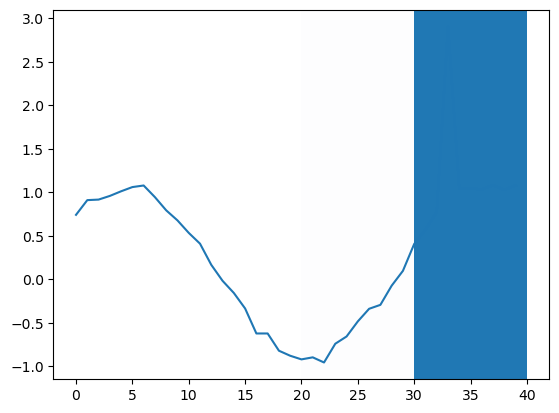

1/1 [==============================] - 0s 18ms/step
[0.01030853 0.01129058 0.02045456 0.99800557]


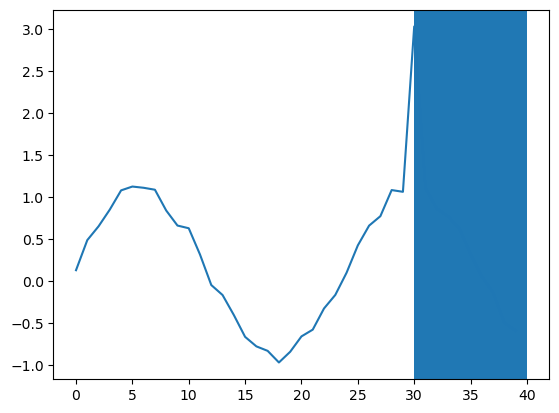

1/1 [==============================] - 0s 17ms/step
[0.01017835 0.00967542 0.03089509 0.01046623]


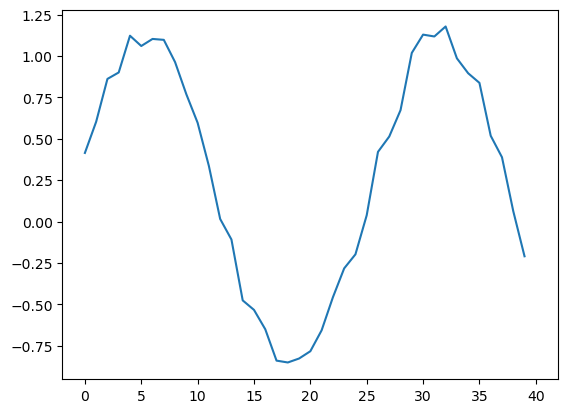

In [206]:
for i in np.random.randint(0, len(X_test), 10):
    colors = model_slice.predict(X_test[i:i+1]).flatten()
    print(colors)
    plt.plot(X_test[i])
    for j, q in enumerate(colors):
        plt.axvspan(j*INTERVAL_LENGTH, j*INTERVAL_LENGTH+INTERVAL_LENGTH, alpha=q**2)
    plt.show()

### All Defects simultaneous Localization